# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [5]:
!pip --proxy http://webgateway.itm.mcafee.com:9090 install pyspark

In [ ]:
# !pip freeze

In [6]:
# import libraries
from pyspark.sql import SparkSession, Row
import pyspark.sql.functions as F
from pyspark.sql.functions import col, isnan, count, when, countDistinct, concat, max, min, sum
from pyspark.sql.window import Window 
from pyspark.ml.feature import VectorAssembler, StandardScaler, Normalizer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [7]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [8]:
## Load the data into dataframe and persist the data
data = 'mini_sparkify_event_data.json'
df = spark.read.json(data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [9]:
## print the schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
## dataframe shape
df.count(), len(df.columns)

(286500, 18)

In [11]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [12]:
## count of null in each column)
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [13]:
## delete rows with null userID or sessionId
df = df.na.drop(subset=["userId","sessionId"])
df = df.filter(df['userId']!='')

In [14]:
## check dataframe shape
df.count(), len(df.columns)

(278154, 18)

In [15]:
## List of unique users and the number 
num_users = df.groupBy('userId').count().agg({"count":"count"})
num_users = num_users.collect()[0][0]
num_users

225

In [16]:
## List of unique churned users and the number 
churn_users = [x.userId for x in df.filter(F.col("page").contains('Cancellation Confirmation')).select('userId').sort('userId').distinct().collect()]
num_churn = len(churn_users)
num_churn

52

In [17]:
## List of unique users who did not churn and the number 
num_non_churn = num_users - num_churn
num_non_churn

173

In [18]:
print('{}% of the users churn'.format(round(num_churn/num_users*100)))

23% of the users churn


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [19]:
## unique value of page column
df.select('page').distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [20]:
##  Add label = 1 for churn, else = 0
df = df.withColumn(
    'label',
    F.when((F.col("userId").isin(churn_users)), 1)
    .otherwise(0)
    )

In [21]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|label|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|

In [22]:
## Verify the data
df.filter(df.label==1).show(5)

+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|label|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|        Modjo|Logged In|    Alexi|     F|            0|  Warren|250.93179| paid|Spokane-Spokane V...|   PUT| NextSong|1532482662000|       53|         What I Mean|   200|1538353930000|Mozilla/5.0 (Wind...|    54|    1|
|Edwyn Collins|Logged In|    Alexi|     F|            1|  Warren|  216.842| paid|Spokane-Spokane V...|   PUT| NextSong|1

In [23]:
# Verify the data further
df.groupby(['userId', 'label']).agg(count('label')).sort('userId').show()

+------+-----+------------+
|userId|label|count(label)|
+------+-----+------------+
|    10|    0|         795|
|   100|    0|        3214|
|100001|    1|         187|
|100002|    0|         218|
|100003|    1|          78|
|100004|    0|        1245|
|100005|    1|         216|
|100006|    1|          44|
|100007|    1|         520|
|100008|    0|         940|
|100009|    1|         671|
|100010|    0|         381|
|100011|    1|          23|
|100012|    1|         600|
|100013|    1|        1392|
|100014|    1|         310|
|100015|    1|        1050|
|100016|    0|         638|
|100017|    1|          75|
|100018|    0|        1288|
+------+-----+------------+
only showing top 20 rows



In [24]:
## Count of rows for each churned and not-churned users
df_churn = df.filter(col('label')==1)
df_non_churn = df.filter(col('label')==0)

print(df_churn.count())
print(df_non_churn.count())

44864
233290


In [25]:
## Count of page for canceled users
df_churn.groupby(['page']).count().show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|              Cancel|   52|
|    Submit Downgrade|    9|
|         Thumbs Down|  496|
|                Home| 1672|
|           Downgrade|  337|
|         Roll Advert|  967|
|              Logout|  553|
|       Save Settings|   58|
|Cancellation Conf...|   52|
|               About|   56|
|            Settings|  270|
|     Add to Playlist| 1038|
|          Add Friend|  636|
|            NextSong|36394|
|           Thumbs Up| 1859|
|                Help|  239|
|             Upgrade|  112|
|               Error|   32|
|      Submit Upgrade|   32|
+--------------------+-----+



In [26]:
## Average times the churned users visited each page
df_churn.groupby(['page']).agg(F.count('page') / num_churn).show()

+--------------------+-------------------+
|                page| (count(page) / 52)|
+--------------------+-------------------+
|              Cancel|                1.0|
|    Submit Downgrade|0.17307692307692307|
|         Thumbs Down|  9.538461538461538|
|                Home|  32.15384615384615|
|           Downgrade|  6.480769230769231|
|         Roll Advert| 18.596153846153847|
|              Logout| 10.634615384615385|
|       Save Settings| 1.1153846153846154|
|Cancellation Conf...|                1.0|
|               About| 1.0769230769230769|
|            Settings| 5.1923076923076925|
|     Add to Playlist|  19.96153846153846|
|          Add Friend|  12.23076923076923|
|            NextSong|  699.8846153846154|
|           Thumbs Up|              35.75|
|                Help|  4.596153846153846|
|             Upgrade| 2.1538461538461537|
|               Error| 0.6153846153846154|
|      Submit Upgrade| 0.6153846153846154|
+--------------------+-------------------+



                           Not-Churned     Churned
Submit Downgrade              0.312139    0.173077
Thumbs Down                  11.849711    9.538462
Home                         48.612717   32.153846
Downgrade                     9.930636    6.480769
Roll Advert                  17.144509   18.596154
Logout                       15.450867   10.634615
Save Settings                 1.456647    1.115385
About                         2.537572    1.076923
Settings                      7.190751    5.192308
Add to Playlist              31.722543   19.961538
Add Friend                   21.046243   12.230769
NextSong                   1108.173410  699.884615
Thumbs Up                    61.803468   35.750000
Help                          7.023121    4.596154
Upgrade                       2.236994    2.153846
Error                         1.271676    0.615385
Submit Upgrade                0.734104    0.615385
Cancel                        0.000000    1.000000
Cancellation Confirmation     0

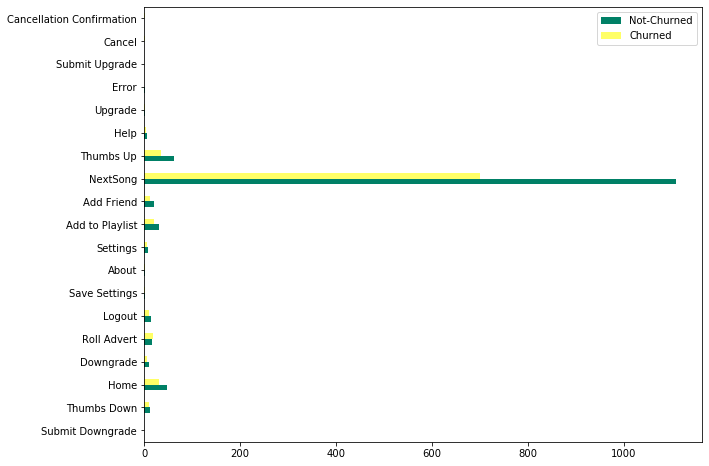

In [27]:
## Avg. page activities for all other users
non_churn_page_avg = df_non_churn.groupby(['page']).agg(F.count('page') / num_non_churn)

## Avg. page activities for canceled users
churn_page_avg = df_churn.groupby(['page']).agg(F.count('page') / num_churn)

## Merge two dataframes to plot a grouped bar graph
graph_df = pd.concat([non_churn_page_avg.toPandas().set_index('page'), churn_page_avg.toPandas().set_index('page')], axis=1, sort=False).fillna(0)
graph_df.columns = ['Not-Churned','Churned']

## Plot a bar graph to show the churn and not-churned users page activities
print(graph_df)
graph_df.plot.barh(figsize=(10,8), colormap='summer')

In [28]:
## preview the female and male counts for users not churned
df_non_churn.groupby(["gender","userId"]).agg({"label":"count"}).groupby("gender").agg({"count(label)":"count"}).show()

+------+-------------------+
|gender|count(count(label))|
+------+-------------------+
|     F|                 84|
|     M|                 89|
+------+-------------------+



In [29]:
## Preview the female/male ratio for users not churned
df_non_churn.groupby(["gender","userId"]).agg({"label":"count"}).groupby("gender").agg(F.count("count(label)") / num_non_churn).show()

+------+---------------------------+
|gender|(count(count(label)) / 173)|
+------+---------------------------+
|     F|        0.48554913294797686|
|     M|         0.5144508670520231|
+------+---------------------------+



In [30]:
## Preview the female/male ratio for churn users 
df_churn.groupby(["gender","userId"]).agg({"label":"count"}).groupby("gender").agg(F.count("count(label)") / num_churn).show()

+------+--------------------------+
|gender|(count(count(label)) / 52)|
+------+--------------------------+
|     F|       0.38461538461538464|
|     M|        0.6153846153846154|
+------+--------------------------+



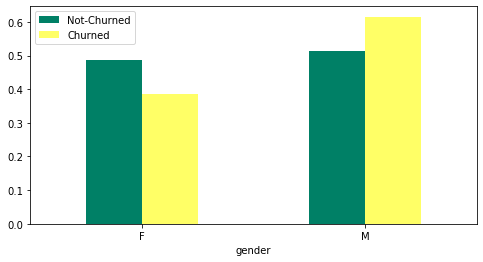

In [31]:
## Percentage of Male and Female in each Churn / not-Churn group
df_gender_pct = df_non_churn.groupby(["gender","userId"]).agg({"label":"count"}).groupby("gender").agg(F.count("count(label)") / num_non_churn)     
df_gender_churn_pct = df_churn.groupby(["gender","userId"]).agg({"label":"count"}).groupby("gender").agg(F.count("count(label)") / num_churn)
graph_gender_pct_df = pd.concat([df_gender_pct.toPandas().set_index('gender'), df_gender_churn_pct.toPandas().set_index('gender')], axis=1, sort=False).fillna(0)
graph_gender_pct_df.columns = ['Not-Churned','Churned']
## Plot a bar graph for churn rate by gender
graph_gender_pct_df.plot.bar(figsize=(8,4), rot=0, colormap='summer')

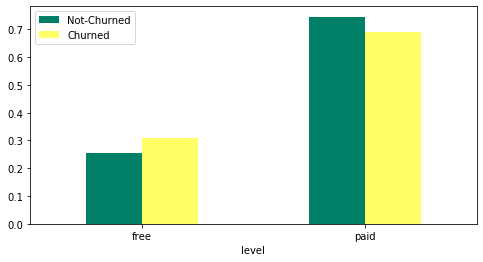

In [32]:
## paid vs free.  Users who upgraded from free to paid will be counted as paid
df_level = df_non_churn.groupby(["level","userId"]).agg({"label":"count"}).sort(col("userId").asc(),col("level").desc()).dropDuplicates(subset = ['userId']).groupby("level").agg(F.count("count(label)") / num_non_churn)
df_level_churn = df_churn.groupby(["level","userId"]).agg({"label":"count"}).sort(col("userId").asc(),col("level").desc()).dropDuplicates(subset = ['userId']).groupby("level").agg(F.count("count(label)") / num_churn)
graph_level_df = pd.concat([df_level.toPandas().set_index('level'), df_level_churn.toPandas().set_index('level')], axis=1, sort=False).fillna(0)
graph_level_df.columns = ['Not-Churned','Churned']
## Plot a bar graph for churn rate by level (paid/free)
graph_level_df.plot.bar(figsize=(8,4), rot=0, colormap='summer')

In [33]:
## Preview the count of page activities per session ID for each user
df_churn.groupBy('userId','sessionId').agg({"page":"count"}).show()

+------+---------+-----------+
|userId|sessionId|count(page)|
+------+---------+-----------+
|   101|      635|        855|
|   122|      691|          9|
|    29|     1030|         19|
|    53|     1306|        182|
|100013|       13|         52|
|200021|      181|        207|
|   101|      496|        423|
|    54|     1308|         20|
|    70|     1385|         16|
|100009|      126|         75|
|300001|      366|         30|
|    12|      379|        240|
|     3|      374|         48|
|100023|      109|         14|
|100014|       98|         93|
|    17|      590|         13|
|    51|      737|        456|
|    12|     1072|         68|
|100021|       21|         14|
|    87|      300|         50|
+------+---------+-----------+
only showing top 20 rows



[Text(0, 0, 'Avg. Count of Pages Per Session')]

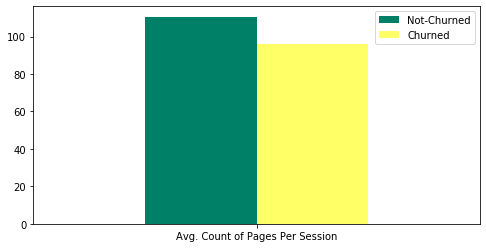

In [34]:
## Average number of activities (pages) in each session for Churn / Not-Churned group
df_avg_session = df.groupBy('label','sessionId').agg({"page":"count"}).groupby('label').agg(F.sum("count(page)") / F.count('sessionId')).toPandas().pivot_table(values='(sum(count(page)) / count(sessionId))', columns='label', aggfunc='first')
df_avg_session.columns = ['Not-Churned','Churned']

## Plot the average count of page activities for churn and not-churned users
ax = df_avg_session.plot.bar(figsize=(8,4), rot=0, colormap='summer')
ax.set_xticklabels(['Avg. Count of Pages Per Session'])

In [100]:
df_avg_session

,Not-Churned,Churned
(sum(count(page)) / count(sessionId)),110.563981,95.863248


In [96]:
df.groupBy('label','artist').agg({"artist":"count"}).groupby('label').agg(F.sum("count(artist)") / num_users).show()

+-----+--------------------------+
|label|(sum(count(artist)) / 225)|
+-----+--------------------------+
|    1|         161.7511111111111|
|    0|         852.0622222222222|
+-----+--------------------------+



[Text(0, 0, 'Avg. No. of Artists')]

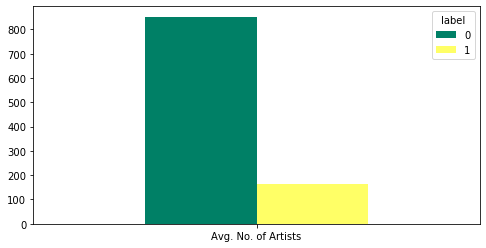

In [117]:
## Average number of artists for Churn / Not-Churned group
df_avg_artist = df.groupBy('label','artist').agg({"artist":"count"}).groupby('label').agg(F.sum("count(artist)") / num_users).toPandas().pivot_table(values='(sum(count(artist)) / 225)', columns='label', aggfunc='first')
df_avg_session.columns = ['Not-Churned','Churned']
# df_avg_artist.columns = ['Not-Churned','Churned']

## Plot the average number of artists for churn and not-churned users
ax = df_avg_artist.plot.bar(figsize=(8,4), rot=0, colormap='summer')
ax.set_xticklabels(['Avg. No. of Artists'])

In [ ]:
## Average number of artists for Churn / Not-Churned group
df_avg_artist = df.groupBy('label','song').agg({"song":"count"}).groupby('label').agg(F.count("count(song)") / num_users).toPandas().pivot_table(values='(sum(count(song)) / 225)', columns='label', aggfunc='first')
df_avg_session.columns = ['Not-Churned','Churned']
# df_avg_artist.columns = ['Not-Churned','Churned']

## Plot the average number of artists for churn and not-churned users
ax = df_avg_artist.plot.bar(figsize=(8,4), rot=0, colormap='summer')
ax.set_xticklabels(['Avg. No. of Songs'])

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [35]:
df.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|label|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|153

In [36]:
## The visit count for each page for each user
df.groupby('userId','page').agg(count('page')).sort('userId').show()    #.pivot('page').agg(count('page')).show()

+------+---------------+-----------+
|userId|           page|count(page)|
+------+---------------+-----------+
|    10|      Downgrade|          7|
|    10|           Help|          1|
|    10|       Settings|          7|
|    10|    Roll Advert|          1|
|    10|    Thumbs Down|          4|
|    10|Add to Playlist|          9|
|    10|      Thumbs Up|         37|
|    10|       NextSong|        673|
|    10|  Save Settings|          1|
|    10|          About|          2|
|    10|           Home|         30|
|    10|         Logout|         11|
|    10|     Add Friend|         12|
|   100|        Upgrade|          1|
|   100|     Add Friend|         49|
|   100|    Roll Advert|         25|
|   100|    Thumbs Down|         27|
|   100|           Help|         18|
|   100| Submit Upgrade|          1|
|   100|Add to Playlist|         61|
+------+---------------+-----------+
only showing top 20 rows



In [111]:
# df.groupBy('userId','artist').agg({"artist":"count"}).groupby('userId').pivot('artist').agg(F.sum("count(artist)")).sort('userId').fillna(0).show()
df.groupBy('userId','artist').agg({"artist":"count"}).groupby('userId').agg(F.count("count(artist)")).sort('userId').fillna(0).show()

+------+--------------------+
|userId|count(count(artist))|
+------+--------------------+
|    10|                 566|
|   100|                1706|
|100001|                 126|
|100002|                 185|
|100003|                  51|
|100004|                 734|
|100005|                 150|
|100006|                  27|
|100007|                 358|
|100008|                 624|
|100009|                 443|
|100010|                 253|
|100011|                  12|
|100012|                 398|
|100013|                 827|
|100014|                 234|
|100015|                 628|
|100016|                 432|
|100017|                  52|
|100018|                 781|
+------+--------------------+
only showing top 20 rows



In [124]:
## Pivot the previous dataframe by the page columne
feature_df = df.groupby('userId','page').agg(count('page')).groupby('userId').pivot('page').agg(F.sum("count(page)")).sort('userId').fillna(0)

## Convert gender info to binary and add to feature_df
temp_df = df.groupby(['userId', 'gender']).agg(count('gender')).sort('userId').select('userId','gender')
temp_df = temp_df.withColumn("gender_bin", F.when((F.col("gender") == "M"), 0).otherwise(1)).select('userId','gender_bin')
feature_df = feature_df.join(temp_df, ['userId'])

## Convert level info to binary and add to feature_df
temp_df = df.groupby(["level","userId"]).agg({"label":"count"}).sort(col("userId").asc(),col("level").desc()).dropDuplicates(subset = ['userId']).select('userId','level')  #.groupby("level").agg(F.count("count(label)") / num_users)
temp_df = temp_df.withColumn("level_bin", F.when((F.col("level") == "paid"), 1).otherwise(0)).select('userId','level_bin')
feature_df = feature_df.join(temp_df, ['userId'])

## Add Avg count of pages per session
temp_df = df.groupBy('userId','sessionId').agg({"page":"count"}).groupby('userId').agg((F.sum("count(page)") / F.count('sessionId')).alias('avg_page_per_session')).sort('userId')
feature_df = feature_df.join(temp_df, ['userId'])

## Add number of artists per user
temp_df = df.groupBy('userId','artist').agg({"artist":"count"}).groupby('userId').agg(F.sum("count(artist)").alias('artist')).sort('userId').fillna(0)
feature_df = feature_df.join(temp_df, ['userId'])

## Lastly, add label
temp_df = df.groupby(['userId', 'label']).agg(count('label')).sort('userId').select('userId','label')
feature_df = feature_df.join(temp_df, ['userId'])

## Delete Cancel pages 
feature_df = feature_df.drop('Cancel','Cancellation Confirmation')

## Verify the number of unique users stayed the same after the table manipulation
feature_df.count()

225

In [125]:
## Verify the data still looks good
feature_df.show(5)

+------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+----------+---------+--------------------+------+-----+
|userId|About|Add Friend|Add to Playlist|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|gender_bin|level_bin|avg_page_per_session|artist|label|
+------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+----------+---------+--------------------+------+-----+
|200002|    3|         4|              8|        5|    0|   2|  20|     5|     387|          7|            0|       3|               0|             1|          6|       21|      2|         0|        1|                79.0|   387|    0|
|100010|    1|         4|              7|        0|    0

In [126]:
## Verify the schema still looks good
feature_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)
 |-- gender_bin: integer (nullable = false)
 |-- level_bin: integer (nullable = false)
 |-- avg_page_per_session: double (nullable = true)
 |-- artist: long (nullable = true)
 |-- label: integer (nullable = false)



In [127]:
page_features = ['About', 'Add Friend', 'Add to Playlist', 'Help',\
                 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down',\
                 'Thumbs Up', 'Downgrade', 'Upgrade', 'NextSong', 'Home', 'Logout', 'artist', 'avg_page_per_session']   ## 'Error'
binary_features = ['gender_bin', 'level_bin']

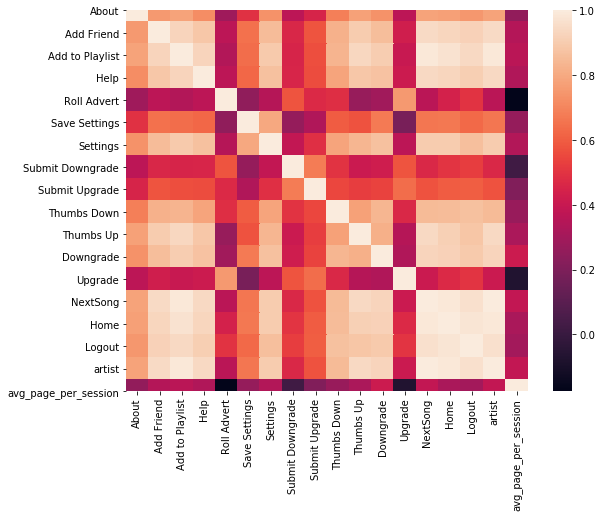

In [128]:
## Check the correlation between page features
corr = feature_df[page_features].toPandas().corr()
## Display a heatmap to show the correlation
fig, ax = plt.subplots(figsize=(9,7)) 
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,ax=ax)

In [152]:
feature_df.toPandas().to_csv('feature_df.csv', encoding='utf-8')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [129]:
## Create transformer and assembler
assembler1 = VectorAssembler(inputCols=page_features, outputCol="vec1")
scaler = StandardScaler(inputCol="vec1", outputCol="scaledFeatures")
assembler2 = VectorAssembler(inputCols=["gender_bin","level_bin","scaledFeatures"], outputCol="features")

In [130]:
## Create Pipeline
pipeline = Pipeline(stages = [assembler1, scaler, assembler2])
pipelineModel = pipeline.fit(feature_df)
feature_df = pipelineModel.transform(feature_df)
feature_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)
 |-- gender_bin: integer (nullable = false)
 |-- level_bin: integer (nullable = false)
 |-- avg_page_per_session: double (nullable = true)
 |-- artist: long (nullable = true)
 |-- label: integer (nullable = false)
 |-- vec1: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = tr

In [131]:
## Split Training and Test sets
train, test = feature_df.randomSplit([0.8, 0.2], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 188
Test Dataset Count: 37


In [132]:
## Verify how many label=1 in the training data
train.filter(F.col('label')==1).count()

41

In [135]:
def display_coefficients(model):
    '''
    Displays coeeficients plot if available in the model
    '''
    beta = np.sort(model.coefficients)
    plt.plot(beta)
    plt.ylabel('Beta Coefficients')
    plt.show()
    
def display_ROC(model):
    '''
    Displays ROC curve for the model
    '''
    try:
        trainingSummary = model.summary
    except:
        trainingSummary = model.stages[-1].summary
    roc = trainingSummary.roc.toPandas()
    plt.plot(roc['FPR'],roc['TPR'])
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

def display_precision_recall(model):
    '''
    Displays precision and recall plot
    '''
    try:
        trainingSummary = model.summary
    except:
        trainingSummary = model.stages[-1].summary
    pr = trainingSummary.pr.toPandas()
    plt.plot(pr['recall'],pr['precision'])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()
    
def display_accuracy(model, alg):
    '''
    Displays the accuracy rate, ROC value and confusion matrix (tp, fp, tn, fn counts)
    '''
    prediction = model.transform(test)
    tp = prediction.filter(prediction.label == prediction.prediction).count()
    total = float(prediction.count())
    accuracy = tp / total
    print(alg)
    print('Accuracy: Predicted {} out of {} ({})'.format(tp, total, accuracy))
    evaluator = BinaryClassificationEvaluator()
    print('Test Area Under ROC: {}\n'.format(evaluator.evaluate(prediction)))
    
    print('TP: {}'.format(prediction.filter((F.col("prediction")==1) & (F.col("label")==1)).count()))
    print('TN: {}'.format(prediction.filter((F.col("prediction")==0) & (F.col("label")==0)).count()))
    print('FP: {}'.format(prediction.filter((F.col("prediction")==1) & (F.col("label")==0)).count()))
    print('FN: {}'.format(prediction.filter((F.col("prediction")==0) & (F.col("label")==1)).count()))
    
    return evaluator, prediction

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    '''
    Matches feature importances attributes from the model
    to the feature names
    '''
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

#### Train and Fit Logistic Regression

In [136]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

lr_evaluator, lr_prediction = display_accuracy(lrModel, 'Logistic Regression')

Logistic Regression
Accuracy: Predicted 24 out of 37.0 (0.6486486486486487)
Test Area Under ROC: 0.5174825174825175

TP: 1
TN: 23
FP: 3
FN: 10


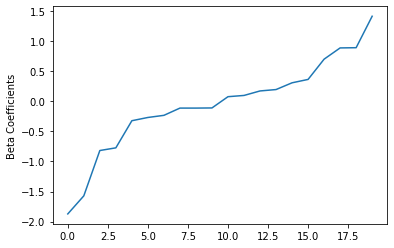

In [137]:
## Display coefficients graph of the linear Regression model
display_coefficients(lrModel)

C:\Users\kdeside1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\kdeside1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\kdeside1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


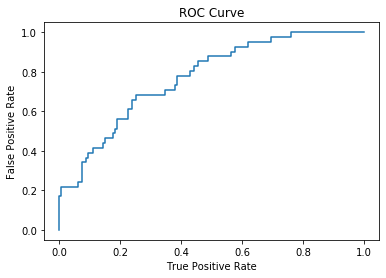

Training set areaUnderROC: 0.7703666832586692


In [138]:
## display ROC curve of the linear Regression model
display_ROC(lrModel)

C:\Users\kdeside1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\kdeside1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\kdeside1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


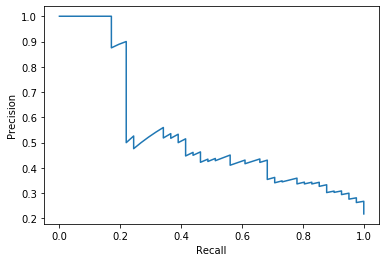

In [139]:
## Display precision and recall graph of the linear Regression model
display_precision_recall(lrModel)

In [140]:
## Print hyperparameters of Linear Regressions
print(lrModel.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [141]:
## Print the model attributes
print(dir(lrModel))

['__abstractmethods__', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_call_java', '_checkThresholdConsistency', '_copyValues', '_copy_params', '_create_from_java_class', '_create_params_from_java', '_defaultParamMap', '_dummy', '_empty_java_param_map', '_from_java', '_java_obj', '_make_java_param_pair', '_new_java_array', '_new_java_obj', '_paramMap', '_params', '_randomUID', '_resetUid', '_resolveParam', '_set', '_setDefault', '_shouldOwn', '_testOwnParam', '_to_java', '_transfer_param_map_from_java', '_transfer_param_map_to_java', '_transfer_params_from_java', '_transfer_params_to_java', '_trans

In [142]:
## check the confidence level of each prediction
lr_prediction.select('label','prediction','rawPrediction').show(50, False)

+-----+----------+------------------------------------------+
|label|prediction|rawPrediction                             |
+-----+----------+------------------------------------------+
|1    |0.0       |[0.9832121957089808,-0.9832121957089808]  |
|1    |0.0       |[1.759464275067816,-1.759464275067816]    |
|0    |0.0       |[4.1883718349066665,-4.1883718349066665]  |
|0    |0.0       |[3.365294242523822,-3.365294242523822]    |
|1    |0.0       |[2.07252011856805,-2.07252011856805]      |
|1    |0.0       |[1.332695887393505,-1.332695887393505]    |
|1    |0.0       |[0.9052553810839561,-0.9052553810839561]  |
|0    |0.0       |[0.8488441904588181,-0.8488441904588181]  |
|0    |0.0       |[0.7258955441122185,-0.7258955441122185]  |
|0    |0.0       |[0.63323250864613,-0.63323250864613]      |
|0    |0.0       |[2.442060959542963,-2.442060959542963]    |
|1    |0.0       |[1.078573208720163,-1.078573208720163]    |
|1    |0.0       |[2.1202240500859966,-2.1202240500859966]  |
|0    |0

In [149]:
## Linear Regression Model Tuning
# paramGrid = ParamGridBuilder()\
#             .addGrid(lrModel.maxIter,[30, 50])\
#             .addGrid(lrModel.regParam,[0.2,0.4])\
#             .build()

paramGrid = ParamGridBuilder()\
            .addGrid(lrModel.threshold,[0.2, 0.3, 0.4])\
            .build()

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=lr_evaluator, numFolds=5)
cvModel = cv.fit(train)
display_accuracy(cvModel, 'Linear Regression Tuned')

Linear Regression Tuned
Accuracy: Predicted 18 out of 37.0 (0.4864864864864865)
Test Area Under ROC: 0.5174825174825175

TP: 6
TN: 12
FP: 14
FN: 5


(BinaryClassificationEvaluator_0b72896170ab,
 DataFrame[userId: string, About: bigint, Add Friend: bigint, Add to Playlist: bigint, Downgrade: bigint, Error: bigint, Help: bigint, Home: bigint, Logout: bigint, NextSong: bigint, Roll Advert: bigint, Save Settings: bigint, Settings: bigint, Submit Downgrade: bigint, Submit Upgrade: bigint, Thumbs Down: bigint, Thumbs Up: bigint, Upgrade: bigint, gender_bin: int, level_bin: int, avg_page_per_session: double, artist: bigint, label: int, vec1: vector, scaledFeatures: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double])

#### Train and Fit Decision Tree

In [143]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)

dt_evaluator, dt_prediction = display_accuracy(dtModel, 'Decision Tree')

Decision Tree
Accuracy: Predicted 26 out of 37.0 (0.7027027027027027)
Test Area Under ROC: 0.7115384615384616

TP: 0
TN: 26
FP: 0
FN: 11


In [144]:
## Check the confidence level for each prediction
dt_prediction.select('label','prediction','rawPrediction').show(50, False)

+-----+----------+-------------+
|label|prediction|rawPrediction|
+-----+----------+-------------+
|1    |0.0       |[93.0,33.0]  |
|1    |0.0       |[93.0,33.0]  |
|0    |0.0       |[45.0,2.0]   |
|0    |0.0       |[45.0,2.0]   |
|1    |0.0       |[93.0,33.0]  |
|1    |0.0       |[93.0,33.0]  |
|1    |0.0       |[93.0,33.0]  |
|0    |0.0       |[93.0,33.0]  |
|0    |0.0       |[93.0,33.0]  |
|0    |0.0       |[93.0,33.0]  |
|0    |0.0       |[45.0,2.0]   |
|1    |0.0       |[93.0,33.0]  |
|1    |0.0       |[93.0,33.0]  |
|0    |0.0       |[93.0,33.0]  |
|0    |0.0       |[9.0,1.0]    |
|0    |0.0       |[45.0,2.0]   |
|0    |0.0       |[45.0,2.0]   |
|0    |0.0       |[93.0,33.0]  |
|0    |0.0       |[93.0,33.0]  |
|0    |0.0       |[93.0,33.0]  |
|0    |0.0       |[93.0,33.0]  |
|0    |0.0       |[93.0,33.0]  |
|0    |0.0       |[9.0,1.0]    |
|0    |0.0       |[93.0,33.0]  |
|1    |0.0       |[93.0,33.0]  |
|0    |0.0       |[93.0,33.0]  |
|0    |0.0       |[93.0,33.0]  |
|0    |0.0

In [145]:
## Print the Decision Tree model attributes
# print(dir(dtModel))

#### Train and Fit Random Forest

In [146]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)

rf_evaluator, rf_prediction = display_accuracy(rfModel, 'Random Forest')

Random Forest
Accuracy: Predicted 27 out of 37.0 (0.7297297297297297)
Test Area Under ROC: 0.5909090909090909

TP: 1
TN: 26
FP: 0
FN: 10


In [153]:
## Print the Random Forest model attributes
print(dir(rfModel))

['__abstractmethods__', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_call_java', '_copyValues', '_copy_params', '_create_from_java_class', '_create_params_from_java', '_defaultParamMap', '_dummy', '_empty_java_param_map', '_from_java', '_java_obj', '_make_java_param_pair', '_new_java_array', '_new_java_obj', '_paramMap', '_params', '_randomUID', '_resetUid', '_resolveParam', '_set', '_setDefault', '_shouldOwn', '_testOwnParam', '_to_java', '_transfer_param_map_from_java', '_transfer_param_map_to_java', '_transfer_params_from_java', '_transfer_params_to_java', '_transform', 'bootstrap', 'cacheNode

In [154]:
## Print the hyperparameters of Random Forest
print(rfModel.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

In [156]:
## Random Forest Model Tuning
paramGrid = ParamGridBuilder()\
            .addGrid(rfModel.bootstrap, [True, False])\
            .addGrid(rfModel.maxDepth, [2, 5, 8])\
            .addGrid(rfModel.featureSubsetStrategy, ['auto','sqrt','onethird'])\
            .build()

cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=rf_evaluator, numFolds=5)
cv_rf_Model = cv_rf.fit(train)
cv_rf_evaluator, cv_rf_prediction = display_accuracy(cv_rf_Model, 'Random Forest Tuned')

Random Forest Tuned
Accuracy: Predicted 28 out of 37.0 (0.7567567567567568)
Test Area Under ROC: 0.5751748251748253

TP: 2
TN: 26
FP: 0
FN: 9


In [173]:
cv_rf_prediction

DataFrame[userId: string, About: bigint, Add Friend: bigint, Add to Playlist: bigint, Downgrade: bigint, Error: bigint, Help: bigint, Home: bigint, Logout: bigint, NextSong: bigint, Roll Advert: bigint, Save Settings: bigint, Settings: bigint, Submit Downgrade: bigint, Submit Upgrade: bigint, Thumbs Down: bigint, Thumbs Up: bigint, Upgrade: bigint, gender_bin: int, level_bin: int, avg_page_per_session: double, artist: bigint, label: int, vec1: vector, scaledFeatures: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [178]:
cv_rf_prediction.select('label','prediction','rawPrediction','probability').show(50, False)

+-----+----------+----------------------------------------+-----------------------------------------+
|label|prediction|rawPrediction                           |probability                              |
+-----+----------+----------------------------------------+-----------------------------------------+
|1    |0.0       |[18.03465447807553,1.9653455219244695]  |[0.9017327239037766,0.09826727609622347] |
|1    |0.0       |[10.570833333333333,9.429166666666667]  |[0.5285416666666667,0.47145833333333337] |
|0    |0.0       |[19.9375,0.0625]                        |[0.996875,0.003125]                      |
|0    |0.0       |[17.97222222222222,2.0277777777777777]  |[0.898611111111111,0.10138888888888889]  |
|1    |0.0       |[19.024175072710722,0.9758249272892734] |[0.9512087536355363,0.04879124636446368] |
|1    |0.0       |[12.881317204301077,7.118682795698924]  |[0.6440658602150539,0.3559341397849462]  |
|1    |0.0       |[16.753697467407143,3.2463025325928543] |[0.8376848733703574,0.1

In [163]:
## extract rawPrediction column from the prediction output
score_col = cv_rf_prediction.toPandas()['rawPrediction']

## Take the 2nd element of the list and put into an array
score_array = []
for i in score_col:
    score_array.append(i[1])

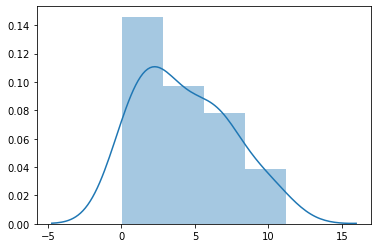

In [172]:
## Plot the distribution of the rawPrediction score.  
sns.distplot(score_array)

In [174]:
## Extract the probability column from the prediction output
prob_col = cv_rf_prediction.toPandas()['probability']

## Take the 2nd element of the list and put into an array
prob_array = []
for i in prob_col:
    prob_array.append(i[1])

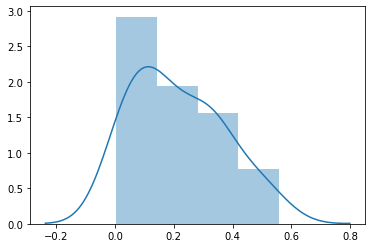

In [177]:
## Plot the distribution of the probability score
sns.distplot(prob_array)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.